# Building Content Intelligence: A Multi-Platform Content Generation Agent with LangGraph

## Overview
This tutorial demonstrates how to build Content Intelligence, an advanced content generation agent using LangGraph. The agent is designed to transform input text into platform-optimized content across multiple social media channels, incorporating research-driven insights and maintaining brand consistency throughout the process.

## Motivation
Content creation for multiple platforms is a complex, time-consuming task that requires understanding platform-specific requirements, audience preferences, and maintaining consistent messaging. Content Intelligence automates this process by:
- Analyzing and summarizing input content
- Conducting research to enhance content quality
- Generating platform-specific content while maintaining brand voice
- Managing complex workflows through a structured graph approach

## Key Components

### 1. State Management
The agent uses TypedDict and Pydantic models to maintain strict type safety and manage various states throughout the content generation process:

```python
class InputState(TypedDict):
    text: str
    platforms: list[Platform]

class SumamryOutputState(TypedDict):
    text: str
    text_summary: str
    platforms: list[Platform]

class ResearchOutputState(TypedDict):
    text: str
    research: str
    platforms: list[Platform]
```

These state definitions ensure clean data flow between different stages of the content generation process.

### 2. Agent Nodes
The system is composed of several specialized nodes:

#### a. Summary Node
- Processes input text to create concise summaries
- Uses GPT-4 for high-quality content understanding
- Maintains key messages while reducing content length

#### b. Research Node
- Conducts platform-specific research using Tavily Search
- Generates relevant questions based on content context
- Analyzes successful content patterns and trends

#### c. Platform-Specific Nodes
- Instagram: Focuses on visual storytelling and engagement
- Twitter: Optimizes for brevity and viral potential
- LinkedIn: Emphasizes professional insights and thought leadership
- Blog: Creates comprehensive, SEO-optimized content

## Agent Architecture

### 1. Workflow Design
The agent uses LangGraph's StateGraph to create a structured workflow:

![ContentIntelligence](../images/contentIntelli.svg)

### 2. Data Flow
1. Input text enters the summary node for initial processing
2. Summarized content moves to the research node for enhancement
3. Intent matching distributes content to platform-specific nodes
4. Each platform node generates optimized content
5. Final content is combined and returned

### 3. Platform-Specific Processing
Each platform has dedicated prompts tailored to its unique requirements:

```python
instagram_prompt = ChatPromptTemplate.from_template("""
You are a creative social media strategist specializing in Instagram content.  

**Input Details:**  
1. Text: {text}  
2. Research: {research}  

Your task is to create an **Instagram post caption** with:
- Engaging Caption
- Hashtag Suggestions
- Call-to-Action (CTA)
- Emoji Usage
...
""")
```

## Implementation Benefits

1. **Modularity**
   - Easy to add new platforms or modify existing ones
   - Independent optimization of each component
   - Simple maintenance and updates

2. **Quality Control**
   - Type safety throughout the pipeline
   - Consistent brand voice across platforms
   - Research-backed content generation

3. **Scalability**
   - Parallel processing of platform-specific content
   - Efficient handling of multiple content pieces
   - Easy integration with existing systems

## Educational Applications

This agent serves as an excellent example for learning:
1. **Graph-Based AI Systems**
   - Understanding state management in complex workflows
   - Implementing typed data flows
   - Managing parallel processing paths

2. **Prompt Engineering**
   - Platform-specific prompt design
   - Context management across multiple steps
   - Maintaining consistency across different models

3. **System Architecture**
   - Building modular AI systems
   - Managing complex workflows
   - Implementing type-safe AI applications

## Conclusion

Content Intelligence demonstrates the power of LangGraph in creating sophisticated content generation workflows. By combining state management, research capabilities, and platform-specific optimization, we've created a system that can efficiently handle complex content generation tasks while maintaining quality and consistency.

This tutorial provides a foundation for building similar agents, whether for content generation or other domains requiring complex workflow management. The principles demonstrated here – modular design, type safety, and structured workflows – can be applied to various AI agent development scenarios.

## Next Steps

1. **Extend the Agent**
   - Add more social media platforms
   - Implement image generation capabilities
   - Add content performance tracking

2. **Optimize Performance**
   - Fine-tune prompts for better results
   - Implement caching for research results
   - Add error handling and retry mechanisms

3. **Enhance Features**
   - Add A/B testing capabilities
   - Implement feedback loops
   - Add content scheduling functionality

Remember, the key to building successful agents is understanding both the technical implementation and the specific requirements of your use case. This tutorial provides a framework that can be adapted and extended to meet various content generation needs.

In [12]:
%%capture --no-stderr
%pip install langgraph langchain-community tavily-python langchain_openai langchain_core langchain

In [14]:
import os
import getpass


def _set_env(name: str):
    if not os.getenv(name):
        os.environ[name] = getpass.getpass(f"{name}: ")


_set_env("OPENAI_API_KEY")

In [16]:
_set_env("LANGCHAIN_API_KEY")
_set_env("LANGCHAIN_ENDPOINT")
_set_env("LANGCHAIN_PROJECT")
_set_env("LANGCHAIN_TRACING_V2")

In [18]:
_set_env("TAVILY_API_KEY")

In [19]:
user_details = {
  "user_name": "LangGraph Team",
  "business_name": "LangGraph",
  "industry": "AI Tools and Frameworks",
  "business_type": "Tech Startup",
  "target_audience": ["AI Developers", "Machine Learning Enthusiasts", "Enterprise AI Teams"],
  "tone": "Professional",
  "objectives": ["Awareness", "Education"],
  "platforms": ["LinkedIn", "Twitter", "Medium"],
  "preferred_platforms": ["LinkedIn", "Twitter"],
  "platform_specific_details": {
    "twitter_handle": "@LangGraphAI",
    "linkedin_page": "linkedin.com/company/langgraph",
    "medium_page": "medium.com/langgraph"
  },
  "campaigns": [
    {
      "title": "Memory Management Module Launch",
      "date": "2024-05-20",
      "platform": "LinkedIn",
      "success_metric": "1000+ Shares"
    }
  ],
  "popular_hashtags": ["#LangGraph", "#MemoryManagement", "#AIFrameworks"],
  "themes": ["Memory Management", "AI Agent Development"],
  "short_length": 280,
  "long_length": 2000,
  "assets_link": "https://drive.google.com/drive/folders/langgraph-assets",
  "colors": ["#1E88E5", "#FFC107"],
  "brand_keywords": ["Innovative", "Efficient"],
  "restricted_keywords": ["Buggy", "Outdated"],
  "competitors": ["LangChain", "Pinecone"],
  "competitor_metrics": ["Content Shares", "Follower Growth"],
  "posting_schedule": ["Tuesday 10 AM", "Friday 3 PM"],
  "formats": ["Carousel", "Technical Blog"],
  "personal_preferences": "Use technical terms but keep explanations concise."
}

# Let's Define States for the Agent

In [47]:
from typing_extensions import TypedDict, List, Literal
from pydantic import BaseModel
from langgraph.graph.message import MessagesState
import operator
from typing import Annotated

Platform = Literal["Twitter","Linkedin","Instagram", "Blog"]

class InputState(TypedDict):
    text: str
    platforms: list[Platform]

class SumamryOutputState(TypedDict):
    text: str
    text_summary: str
    platforms: list[Platform]

class ResearchOutputState(TypedDict):
    text: str
    research: str
    platforms: list[Platform]

class IntentMatchingInputState(TypedDict):
    text: str
    research: str
    platforms: list[Platform]

class FinalState(TypedDict):
    contents: Annotated[list, operator.add]

class GeneratedContent(TypedDict):
    generated_content: str

# Let's Define our Agent Nodes:



In [30]:
from pydantic import BaseModel, Field
from langchain.prompts import ChatPromptTemplate
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI

# some intitializations
summ_model = ChatOpenAI(model = "gpt-4o-mini", temperature=0.6)

model = ChatOpenAI(model = "gpt-4o", temperature=0.6)

sumamry_prompt = ChatPromptTemplate.from_template("""
Taks: You need to give a summary of this given text. This summary will help the user to get the idea of the whole text. Do not miss anything important as this summary will take place in Research.

Text:
 {text}

""")

research_agent_prompt = ChatPromptTemplate.from_template("""
You are a member of the Content Generation Team. Your primary task is to research and analyze the provided details to enhance the content creation process.

Here are the client's details:
{user_details}

Below is the summary of the content for which the client wants to generate textual material:
{text_summary}

The client wants to create content for the following platforms:
{platforms}

Your task is to focus on content development enhancements. For each platform, generate onyl 2 questions :

- Suggest best keywords or hashtags relevant to the platform and the content intent.
- Identify key points or themes that should be highlighted or have been emphasized in previous posts.
- Propose possible content elements or formats (e.g., lists, visuals, tone adjustments) tailored to the platform's audience and characteristics.
- .... Anything which is enhances content


Response Format:
[
question1",
 question2",...
]
""")



In [31]:
from langchain_community.tools import TavilySearchResults
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables import RunnableConfig
from langgraph.types import Send

research_tool = TavilySearchResults(
    max_results=2,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

class ReserachQuestions(TypedDict):
    questions: List[str]

def summary_text(state: InputState) -> SumamryOutputState:
    print("******* Generating summary of the given text *************")
    summary = summ_model.invoke(state["text"]).content
    return {"text": state["text"], "platforms": state["platforms"], "text_summary": summary}

def research_node(state: SumamryOutputState) -> ResearchOutputState:
    print("******* Researching for the best content *************")
    input_ = {"user_details": user_details, "text_summary": state["text_summary"], "platforms": state["platforms"]}
    res = model.with_structured_output(ReserachQuestions, strict=True).invoke(research_agent_prompt.invoke(input_))
    response = research_tool.batch(res["questions"])
    research = ""
    for i,ques in enumerate(res["questions"]):
        research += "question: " + ques + "\n"
        research += "Answers" + "\n\n".join([res["content"] for res in response[i]]) + "\n\n"
    
    return {"text": state["text"], "platforms": state["platforms"], "research": research}

def IntentMatching(state: ResearchOutputState):
    print("******* Sending data to each Platfrom *************")
    # platform_nodes = []
    # for platform in state["platforms"]:
    #     platform_nodes.append(Send(platform, {"text": state["text"],"research": state["research"], "platform": platform}))
    # return platform_nodes
    {"text": state["text"],"research": state["research"], "platforms": state["platforms"]}


# Let's Make Platform Specific Nodes

In [32]:
instagram_prompt = ChatPromptTemplate.from_template("""
You are a creative social media strategist specializing in Instagram content.  

**Input Details:**  
1. Text: {text}  
2. Research: {research}  

Your task is to create an **Instagram post caption** and provide the following:  
- **Engaging Caption**: Write a compelling caption that aligns with the given text, highlights the key points, and uses an **inspirational or engaging tone** (as per the audience).  
- **Hashtag Suggestions**: Suggest at least 10 hashtags that are **trending and relevant** to the content and target audience.  
- **Call-to-Action (CTA)**: Include a specific action to encourage user engagement (e.g., comment, tag friends, visit website).  
- **Emoji Usage**: Add appropriate emojis to make the caption lively and engaging, without overdoing it.  

**Special Guidelines:**  
1. Keep the caption within 2200 characters but aim for 150–300 characters for better engagement.  
2. Ensure hashtags balance **broad reach (#FitnessGoals)** and **niche relevance (#EcoFitFashion)**.  
3. Optimize for Instagram’s algorithm by starting with a **hook** (e.g., a question or statement).  

**Response Format:**  
Caption: [Your Instagram caption here]  
Hashtags: [#hashtag1, #hashtag2, ...]  
CTA: [Call-to-Action here]  

""")

twitter_prompt = ChatPromptTemplate.from_template("""
You are a social media expert tasked with crafting tweets that drive engagement on Twitter.  

**Input Details:**  
1. Text: {text}  
2. Research: {research}  

Your task is to create **Twitter content** with the following specifications:  
- **Tweet**: Craft a tweet that conveys the essence of the text in **280 characters or less**, ensuring clarity, conciseness, and a conversational tone.  
- **Hashtag Suggestions**: Include up to 3 hashtags that enhance visibility and are platform-specific.  
- **Thread**: If the content cannot fit in a single tweet, create a **thread** with concise, numbered tweets that maintain flow and engagement.  

**Special Guidelines:**  
1. Start with a **strong hook** in the first tweet to grab attention.  
2. Use one or two relevant keywords or phrases identified in the research.  
3. Maintain a balance between **professional** and **relatable** language.  

**Response Format:**  
Tweet: [Your tweet here]  
Hashtags: [#hashtag1, #hashtag2, ...]  
Thread:  
1. [First tweet in the thread]  
2. [Second tweet in the thread]  
...  

""")

linkedin_prompt = ChatPromptTemplate.from_template("""
You are a professional LinkedIn content creator, focused on crafting posts that establish thought leadership and build connections.  

**Input Details:**  
1. Text: {text}  
2. Research: {research}  

Your task is to create a **LinkedIn post** with the following details:  
- **Post Content**: Write a professional, thoughtful post elaborating on the text, tailored to LinkedIn’s audience. Highlight the key takeaways or updates and use a **formal yet engaging tone**.  
- **Hashtags**: Suggest up to 5 hashtags relevant to LinkedIn’s professional audience.  
- **CTA**: Include a CTA encouraging engagement (e.g., “Share your thoughts,” “Let us know how you tackle this,” or “Visit our page for more”).  

**Special Guidelines:**  
1. Aim for **150–300 words**, focusing on storytelling and professional insights.  
2. Structure the post with:  
   - A **hook** to grab attention.  
   - The main body with value-driven insights.  
   - A concluding CTA.  
3. Avoid using jargon unless contextually relevant.  
4. Ensure hashtags are business-focused and professional.  

**Response Format:**  
Post: [Your LinkedIn post here]  
Hashtags: [#hashtag1, #hashtag2, ...]  
CTA: [Call-to-Action here]  

""")

blog_prompt = ChatPromptTemplate.from_template("""
You are a content writer specializing in blogs that captivate readers and provide actionable insights.  

**Input Details:**  
1. Text: {text}  
2. Research: {research}  

Your task is to create a **markdown-formatted blog post** with the following structure:  
- **Title**: Create an eye-catching and SEO-friendly blog title.  
- **Introduction**: Write an engaging opening paragraph that sets the context and hooks the reader.  
- **Main Body**: Elaborate on the text using the research to provide insights, examples, and supporting details. Structure it into sections with headings (H2/H3).  
- **Conclusion**: Summarize key takeaways and include a CTA encouraging readers to take the next step.  

**Special Guidelines:**  
1. Use a tone aligned with the target audience (e.g., casual for general readers, formal for professionals).  
2. Optimize for SEO by incorporating keywords from the research naturally into the content.  
3. Ensure readability by using bullet points, numbered lists, and short paragraphs.  
4. Keep the blog **800–1500 words**.  

**Response Format:**  
```markdown
# [Title of the Blog]  

## Introduction  
[Your introduction here]  

## Section 1: [Heading]  
[Content]  

## Section 2: [Heading]  
[Content]  

## Conclusion  
[Conclusion with CTA]  

""")        

In [38]:
def Insta(state: IntentMatchingInputState) -> FinalState:
    if not "Instagram" in state["platforms"]:
        return {"contents": [""]}
    res = model.invoke(instagram_prompt.invoke({"text": state["text"], "research": state["research"]}))
    return {"contents": [res.content]}

def Twitter(state: IntentMatchingInputState) -> FinalState:
    if not "Twitter" in state["platforms"]:
        return {"contents": [""]}
    res = model.invoke(twitter_prompt.invoke({"text": state["text"], "research": state["research"]}))
    return {"contents": [res.content]}

def Linkedin(state: IntentMatchingInputState) -> FinalState:
    if not "Linkedin" in state["platforms"]:
        return {"contents": [""]}
    res = model.invoke(linkedin_prompt.invoke({"text": state["text"], "research": state["research"]}))
    return { "contents": [res.content]}

def Blog(state: IntentMatchingInputState) -> FinalState:
    if not "Blog" in state["platforms"]:
        return {"contents": [""]}
    res = model.invoke(blog_prompt.invoke({"text": state["text"], "research": state["research"]}))
    return { "contents": [res.content]}

def combining_content(state:FinalState) -> GeneratedContent:
    final_content = ""
    for content in state["contents"]:
        final_content += content + "\n\n"
    return {"generated_content": final_content}

# Defining Graph

In [42]:
from IPython.display import Image, display

from langgraph.graph import StateGraph, START, END

builder = StateGraph(input=InputState, output=GeneratedContent)

# Nodes
builder.add_node("summary_node",summary_text)
builder.add_node("research_node", research_node)
builder.add_node("intent_matching_node", IntentMatching)
builder.add_node("instagram", Insta)
builder.add_node("twitter", Twitter)
builder.add_node("linkedin", Linkedin)
builder.add_node("blog", Blog)
builder.add_node("combine_content", combining_content)


# Flow
builder.add_edge(START, "summary_node")
builder.add_edge("summary_node", "research_node")
builder.add_edge("research_node", "intent_matching_node")
builder.add_edge("intent_matching_node", "instagram")
builder.add_edge("intent_matching_node", "twitter")
builder.add_edge("intent_matching_node", "linkedin")
builder.add_edge("intent_matching_node", "blog")
builder.add_edge("blog", "combine_content")
builder.add_edge("twitter", "combine_content")
builder.add_edge("instagram", "combine_content")
builder.add_edge("linkedin", "combine_content")
builder.add_edge("combine_content", END)


/tmp/ipykernel_37931/1326417490.py:5: LangGraphDeprecationWarning: Initializing StateGraph without state_schema is deprecated. Please pass in an explicit state_schema instead of just an input and output schema.
  builder = StateGraph(input=InputState, output=GeneratedContent)


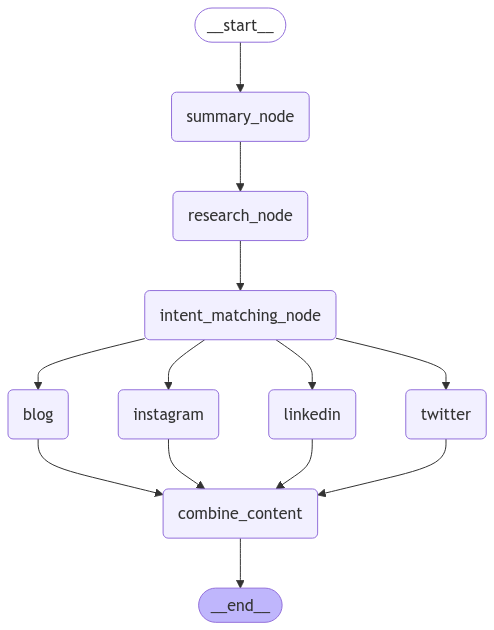

In [43]:
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [44]:
res = graph.invoke({"text": """

LangGraph provides a comprehensive memory management system that supports both short-term and long-term memory, enabling applications to retain and utilize information across interactions effectively. Here’s an overview of both types of memory:

Short-Term Memory
Definition: Short-term memory in LangGraph is designed to manage data within a single conversational thread. It allows the application to remember previous interactions during a session.

Implementation:

Short-term memory is managed as part of the agent's state, which is persisted using thread-scoped checkpoints. This means that the state can be saved and resumed, allowing for continuity in conversations.
It typically includes conversation history, user inputs, and other relevant data that are necessary for maintaining context during interactions.
Use Cases:

Managing conversation history to provide context for ongoing interactions.
Storing temporary data that is relevant only for the duration of a session, such as user preferences or recent queries.
Challenges:

Long conversations can lead to large memory usage, which may exceed the context window of language models. Techniques such as summarization or message trimming are often employed to manage this effectively.
Long-Term Memory
Definition: Long-term memory allows LangGraph applications to retain information across multiple conversational threads and sessions. This type of memory is essential for building personalized user experiences.

Implementation:

Long-term memory is organized into custom namespaces, allowing for hierarchical storage of information. Each memory is stored as a JSON document, making it easy to retrieve and manage.
LangGraph supports various storage backends, including in-memory storage, databases, and other persistent storage solutions.
Use Cases:

Retaining user profiles, preferences, and historical interactions that can be referenced in future conversations.
Storing structured information extracted from conversations, such as facts or knowledge triples, which can enhance the model's responses.
Advantages:

Long-term memory enables applications to provide a more personalized and context-aware experience by recalling past interactions and user-specific information.
Conclusion
LangGraph's memory management system is designed to handle both short-term and long-term memory effectively. Short-term memory focuses on maintaining context within a single session, while long-term memory allows for the retention of information across multiple sessions. This dual approach enhances the capabilities of LangGraph applications, enabling them to deliver more coherent and personalized interactions. By leveraging techniques such as namespaces and structured storage, LangGraph provides a flexible and powerful framework for managing memory in conversational AI applications.


""", "platforms": ["Twitter","Blog"]})

******* Generating summary of the given text *************
******* Researching for the best content *************
******* Sending data to each Platfrom *************


In [46]:
print(res["generated_content"])

```markdown
# Unleashing the Power of Memory Management in LangGraph for AI Excellence

## Introduction  
In the ever-evolving landscape of artificial intelligence, memory management plays a pivotal role in enhancing the capabilities of conversational applications. Enter LangGraph, a revolutionary framework designed to optimize memory usage for AI agents, enabling them to deliver more coherent, context-aware, and personalized interactions. Whether you're an AI developer or a tech enthusiast, understanding the intricacies of LangGraph's memory management system is crucial to harnessing its full potential. This blog delves into the dual approach of short-term and long-term memory in LangGraph, offering insights and actionable strategies to elevate your AI projects.

## Section 1: Mastering Short-Term Memory in LangGraph  
Short-term memory is the cornerstone of maintaining context within a single session, ensuring seamless interactions.

### Definition and Implementation  
LangGraph's sh

# Additional Considerations: Discuss limitations, potential improvements, or specific use cases.

## Limitations
* This can generate only Textual content and only takes text as an input
* It is not optimized with reviers and some other check which can be done by providing special techniques to each platform nodes.


## Potential Improvements
* Image processing ability
* Taking inputs automatically and posting these content automatically
* Adding a Chat interface to let user dicuss things in during research
* Human Review before finalising it

## Specific Use cases
* generate texutal Content with language tone within seconds
* Give insights over the content